# 讀資料

In [1]:
# preprocessing libraries
import pandas as pd
import numpy as np

# visualization libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import torch
import torch.nn as nn
import torch.optim as optim
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

import csv

import os

2024-11-02 20:29:20.427073: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-02 20:29:20.437699: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-02 20:29:20.440982: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-02 20:29:20.449951: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-02 20:29:21.037047: W tensorflow/compiler/tf2

In [3]:
train = pd.read_excel('/mnt/sda1/shuof/HW/HousePricing/data/train.xlsx')
valid = pd.read_excel('/mnt/sda1/shuof/HW/HousePricing/data/valid.xlsx')
test = pd.read_excel('/mnt/sda1/shuof/HW/HousePricing/data/test-reindex-test.xlsx')

In [4]:
df_train = train
df_valid = valid
df_test = test

# 資料處理

## 欄位清理

In [5]:
df_train = df_train.drop(['編號', '解約情形', '棟及號', '交易標的','移轉層次','總樓層數', '非都市土地使用編定' , '有無管理組織' ,'備註', '建案名稱', '建築完成年月', '交易年月日'], axis=1)
df_valid = df_valid.drop(['編號', '解約情形', '棟及號', '交易標的','移轉層次','總樓層數', '非都市土地使用編定' , '有無管理組織' ,'備註', '建案名稱', '建築完成年月', '交易年月日'], axis=1)
df_test = df_test.drop(['編號', '解約情形', '棟及號', '交易標的','移轉層次','總樓層數', '非都市土地使用編定' , '有無管理組織' ,'備註', '建案名稱', '建築完成年月', '交易年月日'], axis=1)

## 移除特定資料離群值

In [6]:
print(f"{df_train['土地移轉總面積平方公尺'].value_counts()}\n")
print(f"{df_train['建物移轉總面積平方公尺'].value_counts()}\n")
print(f"{df_train['車位移轉總面積平方公尺'].value_counts()}\n")
print(f"{df_train['車位總價元'].value_counts()}\n")

土地移轉總面積平方公尺
0.00      1527
9.42       614
6.50       601
25.02      586
6.73       571
          ... 
100.17       1
147.97       1
138.91       1
64.54        1
208.25       1
Name: count, Length: 15079, dtype: int64

建物移轉總面積平方公尺
116.71     276
146.17     235
149.71     231
7029.51    223
150.84     213
          ... 
312.44       1
207.95       1
354.83       1
723.11       1
339.26       1
Name: count, Length: 26133, dtype: int64

車位移轉總面積平方公尺
0.00     89440
26.45     2663
13.75     2379
24.71     2041
31.64     1903
         ...  
95.90        1
67.47        1
51.47        1
66.13        1
98.55        1
Name: count, Length: 6723, dtype: int64

車位總價元
0           98957
1300000     13300
1800000     12793
1500000     12443
1600000     12429
            ...  
797400          1
5960000         1
39500000        1
7210000         1
2252000         1
Name: count, Length: 939, dtype: int64



In [ ]:
# 移除離群值
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['SimHei'] 
rcParams['axes.unicode_minus'] = False  

def scatterplot(feature, df):
    
    pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

    color = sns.color_palette()
    sns.set_style('darkgrid')
    
    df[feature] = pd.to_numeric(df[feature], errors='coerce')

    df.dropna(subset=[feature], inplace=True)

    plt.figure(figsize=(8, 5))  

    sns.scatterplot(x=df[feature], y='總價元', data=df, alpha=0.5)

    plt.title(f'{feature}', fontsize=12)

    plt.xlabel(feature)
    plt.ylabel('總價元')

    plt.show()

    return df

In [8]:
#Z分數
def remove_outliers_zscore(df, column, threshold=3):
    mean = df[column].mean()
    std = df[column].std()
    return df[(df[column] >= mean - threshold * std) & (df[column] <= mean + threshold * std)]

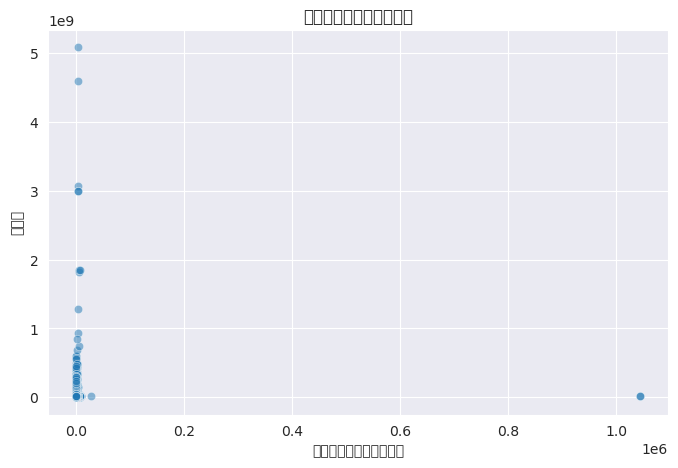

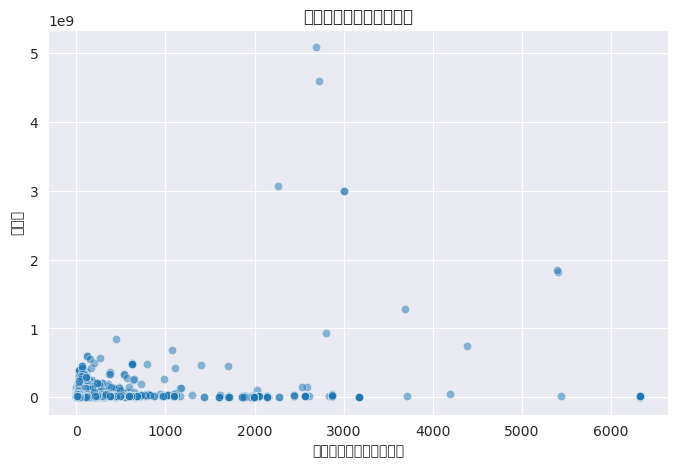

In [9]:
feature = '土地移轉總面積平方公尺'
df_train = scatterplot(feature, df_train)
df_train = remove_outliers_zscore(df_train, feature)
df_train = scatterplot(feature, df_train)

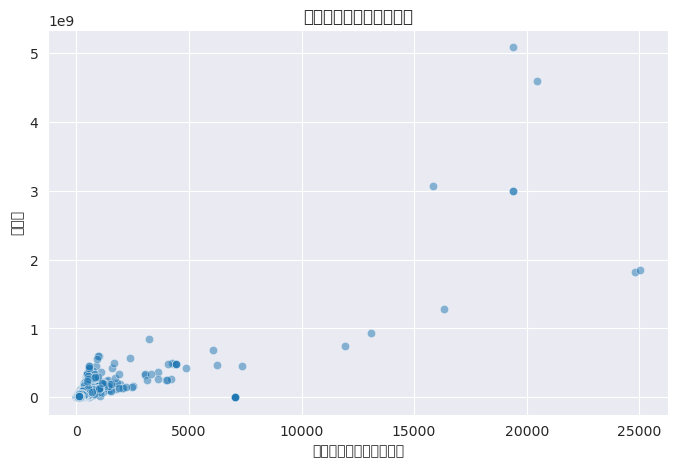

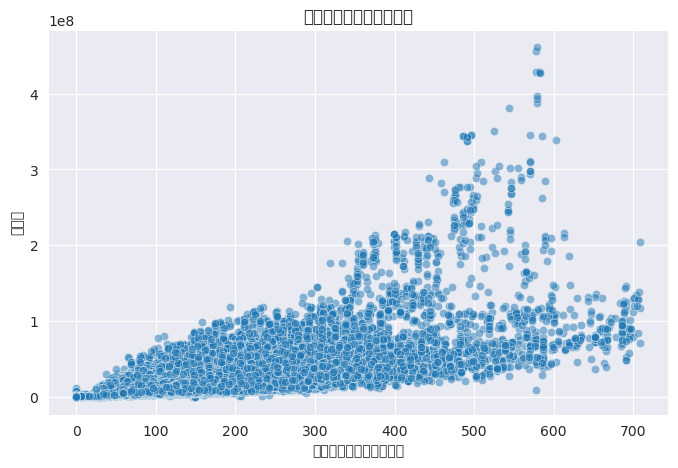

In [10]:
feature = '建物移轉總面積平方公尺'
df_train = scatterplot(feature, df_train)
df_train = remove_outliers_zscore(df_train, feature)
df_train = scatterplot(feature, df_train)

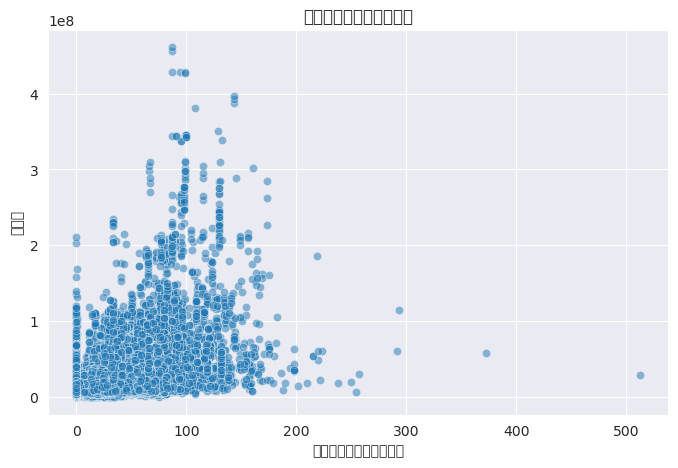

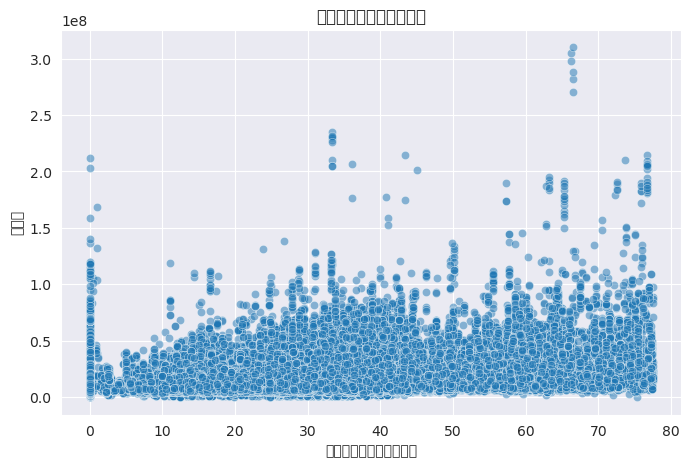

In [11]:
feature = '車位移轉總面積平方公尺'
df_train = scatterplot(feature, df_train)
df_train = remove_outliers_zscore(df_train, feature)
df_train = scatterplot(feature, df_train)

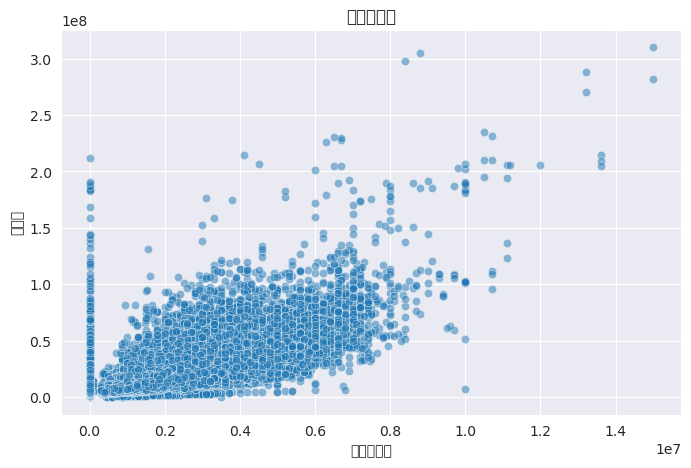

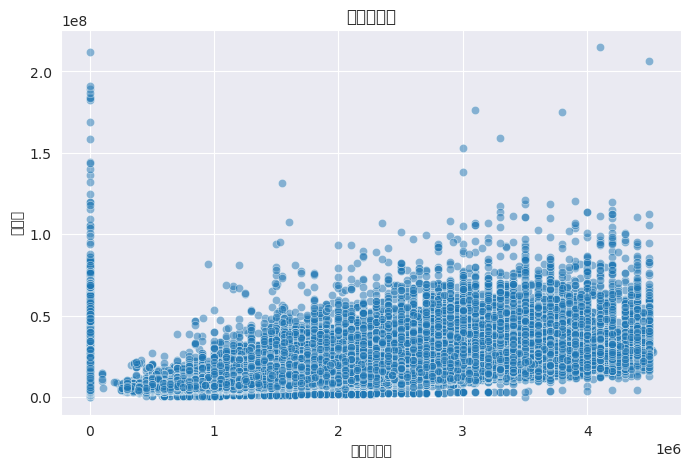

In [12]:
feature = '車位總價元'
df_train = scatterplot(feature, df_train)
df_train = remove_outliers_zscore(df_train, feature)
df_train = scatterplot(feature, df_train)

## 空值處理

In [13]:
# 合併土地使用分區，空值填0
df_train['總土地使用分區'] = df_train['都市土地使用分區'].combine_first(df_train['非都市土地使用分區']).fillna('其他')
df_valid['總土地使用分區'] = df_valid['都市土地使用分區'].combine_first(df_valid['非都市土地使用分區']).fillna('其他')
df_test['總土地使用分區'] = df_test['都市土地使用分區'].combine_first(df_test['非都市土地使用分區']).fillna('其他')

In [14]:
df_train = df_train.drop(['都市土地使用分區', '非都市土地使用分區'], axis=1)
df_valid = df_valid.drop(['都市土地使用分區', '非都市土地使用分區'], axis=1)
df_test = df_test.drop(['都市土地使用分區', '非都市土地使用分區'], axis=1)

In [15]:
# 將主要用途填滿
def fill_main_usage(df):
    conditions = [
        (df['總土地使用分區'] == '住'),
        (df['總土地使用分區'].isin(['商', '工'])),
        (df['總土地使用分區'] == '農'),
        (df['總土地使用分區'] == '其他'),
        (df['總土地使用分區'] == '工業區'),
        (df['總土地使用分區'] == '鄉村區')
    ]
    choices = ['住家用', '工商用','農業用', '工商用', '工業用', '住家用']   
    fill_values = pd.Series(np.select(conditions, choices, default=df['主要用途']), index=df.index)
    df['主要用途'] = df['主要用途'].combine_first(fill_values)
   
    return df

df_train = fill_main_usage(df_train)
df_valid = fill_main_usage(df_valid)
df_test = fill_main_usage(df_test)

In [16]:
df_train['單價元平方公尺'] = df_train['單價元平方公尺'].fillna(df_train['單價元平方公尺'].mean())
df_valid['單價元平方公尺'] = df_valid['單價元平方公尺'].fillna(df_valid['單價元平方公尺'].mean())
df_test['單價元平方公尺'] = df_test['單價元平方公尺'].fillna(df_test['單價元平方公尺'].mean())


# 主要建材空值填0
df_train = df_train.dropna(subset=['主要建材'])
df_valid = df_valid.dropna(subset=['主要建材'])
df_test['主要建材'] = df_test['主要建材'].fillna("見使用執照")


# 車位類別空值填0
df_train['車位類別'] = df_train['車位類別'].fillna("無")
df_valid['車位類別'] = df_valid['車位類別'].fillna("無")
df_test['車位類別'] = df_test['車位類別'].fillna("無")


# 建物現況格局空值填0
for col in ['建物現況格局-房', '建物現況格局-廳', '建物現況格局-衛']:
    df_train[col].fillna(0, inplace=True)
    df_valid[col].fillna(0, inplace=True)
    df_test[col].fillna(0, inplace=True)

In [17]:
from sklearn.preprocessing import StandardScaler

city_to_price = {
    '臺北市': 217000,  
    '台北市': 217000,  
    '新北市': 70000,   
    '新竹市': 40000,  
    '新竹縣': 36000,   
    '基隆市': 30000,  
    '桃園市': 30000,   
    '桃園縣': 30000,   
    '臺中市': 32000,   
    '台中市': 32000,   
    '高雄市': 25000,   
    '臺南市': 25000,   
    '台南市': 25000,
    '彰化縣': 20000,   
    '苗栗縣': 22000,   
    '南投縣': 20000,   
    '嘉義市': 22000,  
    '嘉義縣': 20000,   
    '宜蘭縣': 22000,  
    '雲林縣': 20000,  
    '屏東縣': 20000, 
    '花蓮縣': 18000, 
    '臺東縣': 18000,   
    '金門縣': 18000,
    '澎湖縣': 19000,  
}

# 將 "土地位置建物門牌" 的前三個字作為 "縣市" 的內容
df_train['縣市'] = df_train['土地位置建物門牌'].str[:3]
df_valid['縣市'] = df_valid['土地位置建物門牌'].str[:3]
df_test['縣市'] = df_test['土地位置建物門牌'].str[:3]

# 只保留 "縣市" 是 city_to_price 的資料
df_train = df_train[df_train['縣市'].isin(city_to_price.keys())]
df_valid = df_valid[df_valid['縣市'].isin(city_to_price.keys())]
df_test = df_test[df_test['縣市'].isin(city_to_price.keys())]

# "縣市" 欄位替換成對應的平均房價
df_train['平均房價'] = df_train['縣市'].replace(city_to_price)
df_valid['平均房價'] = df_valid['縣市'].replace(city_to_price)
df_test['平均房價'] = df_test['縣市'].replace(city_to_price)


scaler = StandardScaler()

features_train = df_train[['平均房價']]
scaled_features_train = scaler.fit_transform(features_train)
df_train['平均房價'] = scaled_features_train[:, 0]

features_valid = df_valid[['平均房價']]
scaled_features_valid = scaler.transform(features_valid)
df_valid['平均房價'] = scaled_features_valid[:, 0]

features_test = df_test[['平均房價']]
scaled_features_test = scaler.transform(features_test)
df_test['平均房價'] = scaled_features_test[:, 0]


# 移除原本的 "土地位置建物門牌" 和 "縣市" 欄位
df_train = df_train.drop(['土地位置建物門牌', '縣市'], axis=1)
df_valid = df_valid.drop(['土地位置建物門牌', '縣市'], axis=1)
df_test = df_test.drop(['土地位置建物門牌', '縣市'], axis=1)

In [18]:
df_train = df_train.drop(['鄉鎮市區'], axis=1)
df_valid = df_valid.drop(['鄉鎮市區'], axis=1)
df_test = df_test.drop(['鄉鎮市區'], axis=1)

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

pca = PCA(n_components=1)

area_features_train = df_train[['土地移轉總面積平方公尺', '建物移轉總面積平方公尺','車位移轉總面積平方公尺']]
pca_train_features = pca.fit_transform(area_features_train)
df_train['PCA_area'] = pca_train_features

area_features_valid = df_valid[['土地移轉總面積平方公尺', '建物移轉總面積平方公尺','車位移轉總面積平方公尺']]
pca_valid_features = pca.transform(area_features_valid)
df_valid['PCA_area'] = pca_valid_features

area_features_test = df_test[['土地移轉總面積平方公尺', '建物移轉總面積平方公尺','車位移轉總面積平方公尺']]
pca_test_features = pca.transform(area_features_test)
df_test['PCA_area'] = pca_test_features

In [19]:
use_to_price = {
    '住家用': 60000,     # 住家用房屋的平均房價
    '商業用': 90000,     # 商業用房屋的平均房價
    '住商用': 75000,     # 住商混合用途的平均房價
    '工商用': 70000,     # 工商用房屋的平均房價
    '工業用': 50000,     # 工業用房屋的平均房價
    '住工用': 55000,     # 住工混合用途的平均房價
    '國民住宅': 35000,   # 國民住宅的平均房價
    '停車空間': 20000,   # 停車空間的平均價格
    '農業用': 15000,     # 農業用地的平均價格
    '見使用執照': 60000,  # 需參考使用執照的房價
    '見其他登記事項': 60000,  # 需參考其他登記事項的房價
    '見其它登記事項': 60000,  # 需參考其它登記事項的房價
}

# 1. 將訓練集中的「主要用途」替換為對應的價格
df_train['主要用途'] = df_train['主要用途'].replace(use_to_price)
df_train['主要用途'] = df_train['主要用途'].fillna(np.mean(list(use_to_price.values())))

# 將「主要用途」進行標準化
scaler = StandardScaler()
df_train[['主要用途']] = scaler.fit_transform(df_train[['主要用途']])


# 2. 將驗證集中的「主要用途」替換為對應的價格
df_valid['主要用途'] = df_valid['主要用途'].replace(use_to_price)
df_valid['主要用途'] = df_valid['主要用途'].fillna(np.mean(list(use_to_price.values())))

# 將「主要用途」進行標準化
df_valid[['主要用途']] = scaler.transform(df_valid[['主要用途']])


# 3. 將測試集中的「主要用途」替換為對應的價格
df_test['主要用途'] = df_test['主要用途'].replace(use_to_price)
df_test['主要用途'] = df_test['主要用途'].fillna(np.mean(list(use_to_price.values())))

# 將「主要用途」進行標準化
df_test[['主要用途']] = scaler.transform(df_test[['主要用途']])

In [20]:
zone_to_price = {
    '住': 50.0,        
    '商': 80.0,        
    '工': 30.0,        
    '農': 15.0,        
    '其他': 45.0,      
    '山坡地保育區': 20.0,  
    '特定農業區': 15.0,    
    '鄉村區': 25.0,      
    '一般農業區': 15.0,  
    '工業區': 30.0,     
    '特定專用區': 40.0,  
    '風景區': 60.0      
}

df_train['總土地使用分區'] = df_train['總土地使用分區'].replace(zone_to_price)
df_train['總土地使用分區'] = df_train['總土地使用分區'].fillna(np.mean(list(zone_to_price.values())))

scaler = StandardScaler()
df_train[['總土地使用分區']] = scaler.fit_transform(df_train[['總土地使用分區']])

df_valid['總土地使用分區'] = df_valid['總土地使用分區'].replace(zone_to_price)
df_valid['總土地使用分區'] = df_valid['總土地使用分區'].fillna(np.mean(list(zone_to_price.values())))
df_valid[['總土地使用分區']] = scaler.transform(df_valid[['總土地使用分區']])

df_test['總土地使用分區'] = df_test['總土地使用分區'].replace(zone_to_price)
df_test['總土地使用分區'] = df_test['總土地使用分區'].fillna(np.mean(list(zone_to_price.values())))
df_test[['總土地使用分區']] = scaler.transform(df_test[['總土地使用分區']])

In [21]:
material_to_price = {
    '鋼筋混凝土造': 50.0,
    '鋼筋混凝土構造': 50.0,
    '鋼骨混凝土造': 55.0,
    '鋼骨鋼筋混凝土造': 60.0,
    '鋼筋混凝土加強磚造': 45.0,
    '混凝土造': 40.0,
    '鋼造': 35.0,
    '磚造': 30.0,
    '預力混凝土造': 42.0,
    '石造': 28.0,
    '木造': 25.0,
    '見使用執照': 40.0,  
    '見其他登記事項': 40.0,
    '見其它登記事項': 40.0,  
}

df_train['主要建材'] = df_train['主要建材'].replace(material_to_price)
df_train['主要建材'] = df_train['主要建材'].fillna(np.mean(list(material_to_price.values())))

# 將「主要建材」進行標準化
scaler = StandardScaler()
df_train[['主要建材']] = scaler.fit_transform(df_train[['主要建材']])

df_valid['主要建材'] = df_valid['主要建材'].replace(material_to_price)
df_valid['主要建材'] = df_valid['主要建材'].fillna(np.mean(list(material_to_price.values())))

df_valid[['主要建材']] = scaler.transform(df_valid[['主要建材']])

# 替換 "主要建材" 為對應的價格
df_test['主要建材'] = df_test['主要建材'].replace(material_to_price)
df_test['主要建材'] = df_test['主要建材'].fillna(np.mean(list(material_to_price.values())))

# 將 "主要建材" 進行標準化
df_test[['主要建材']] = scaler.transform(df_test[['主要建材']])

In [22]:
type_to_price = {
    '住宅大樓(11層含以上有電梯)': 50.0,
    '華廈(10層含以下有電梯)': 45.0,
    '店面(店鋪)': 100.0,
    '辦公商業大樓': 80.0,
    '公寓(5樓含以下無電梯)': 35.0,
    '透天厝': 30.0,
    '廠辦': 40.0,
    '工廠': 35.0,
    '套房(1房1廳1衛)': 40.0,
    '倉庫': 30.0,
    '農舍': 20.0,
    '其他': 40.0,
}

df_train['建物型態'] = df_train['建物型態'].replace(type_to_price)
df_train['建物型態'] = df_train['建物型態'].fillna(np.mean(list(type_to_price.values())))

# 將「建物型態」進行標準化
scaler = StandardScaler()
df_train[['建物型態']] = scaler.fit_transform(df_train[['建物型態']])

# 2. 替換驗證集中的「建物型態」為對應的價格
df_valid['建物型態'] = df_valid['建物型態'].replace(type_to_price)
df_valid['建物型態'] = df_valid['建物型態'].fillna(np.mean(list(type_to_price.values())))

# 使用與訓練集相同的 scaler 進行標準化
df_valid[['建物型態']] = scaler.transform(df_valid[['建物型態']])


# 3. 替換測試集中的「建物型態」為對應的價格
df_test['建物型態'] = df_test['建物型態'].replace(type_to_price)
df_test['建物型態'] = df_test['建物型態'].fillna(np.mean(list(type_to_price.values())))

# 使用與訓練集相同的 scaler 進行標準化
df_test[['建物型態']] = scaler.transform(df_test[['建物型態']])

In [23]:
parking_type_to_price = {
    '坡道平面': 150.0,
    '塔式車位': 80.0,
    '坡道機械': 100.0,
    '升降機械': 70.0,
    '升降平面': 90.0,
    '一樓平面': 200.0,
    '其他': 100.0,
    '無': 0.0,
}

# 定義處理函數
def process_parking_features(df):
    # 替換車位類別為對應的價格
    average_price = np.mean(list(parking_type_to_price.values()))
    df['車位類別'] = df['車位類別'].replace(parking_type_to_price)
    df['車位類別'] = df['車位類別'].fillna(average_price)

    # 處理缺失值
    df['車位移轉總面積平方公尺'] = df['車位移轉總面積平方公尺'].fillna(df['車位移轉總面積平方公尺'].median())
    df['車位總價元'] = df['車位總價元'].fillna(df['車位總價元'].median())

    # 計算車位單價（每平方公尺價格）
    df['車位單價元平方公尺'] = df['車位總價元'] / df['車位移轉總面積平方公尺']
    df['車位單價元平方公尺'] = df['車位單價元平方公尺'].replace([np.inf, -np.inf], np.nan).fillna(df['車位單價元平方公尺'].median())

    # 選擇需要進行 PCA 的特徵
    features = df[['車位類別', '車位移轉總面積平方公尺', '車位單價元平方公尺']]

    # 標準化
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    return features_scaled

parking_features_train = process_parking_features(df_train)
parking_features_valid = process_parking_features(df_valid)
parking_features_test = process_parking_features(df_test)

pca = PCA(n_components=1)
parking_pca_train = pca.fit_transform(parking_features_train)
parking_pca_valid = pca.transform(parking_features_valid)
parking_pca_test = pca.transform(parking_features_test)

# 添加 PCA 特徵到原始數據集
df_train['Parking_PCA'] = parking_pca_train
df_valid['Parking_PCA'] = parking_pca_valid
df_test['Parking_PCA'] = parking_pca_test

In [24]:
from sklearn.model_selection import KFold

df_combined = pd.concat([df_train, df_valid], ignore_index=True)
df_combined['隔間_編碼'] = np.nan

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in kf.split(df_combined):
    df_train_fold = df_combined.iloc[train_index]
    df_val_fold = df_combined.iloc[val_index]
    target_mean = df_train_fold.groupby('建物現況格局-隔間')['總價元'].mean()
    df_combined.loc[val_index, '隔間_編碼'] = df_val_fold['建物現況格局-隔間'].map(target_mean)

overall_mean = df_combined['總價元'].mean()
df_combined['隔間_編碼'] = df_combined['隔間_編碼'].fillna(overall_mean)

scaler = StandardScaler()
df_combined['隔間_編碼'] = scaler.fit_transform(df_combined[['隔間_編碼']])

df_train = df_combined.iloc[:len(df_train)].reset_index(drop=True)
df_valid = df_combined.iloc[len(df_train):].reset_index(drop=True)


target_mean_full = df_train.groupby('建物現況格局-隔間')['總價元'].mean()
df_test['隔間_編碼'] = df_test['建物現況格局-隔間'].map(target_mean_full)
df_test['隔間_編碼'] = df_test['隔間_編碼'].fillna(overall_mean)
df_test['隔間_編碼'] = scaler.transform(df_test[['隔間_編碼']])


df_train = df_train.drop(['建物現況格局-隔間'], axis=1)
df_valid = df_valid.drop(['建物現況格局-隔間'], axis=1)
df_test = df_test.drop(['建物現況格局-隔間'], axis=1)

## 新增欄位

In [25]:
df_train['建物平方公尺x單價元'] = df_train['建物移轉總面積平方公尺'] * df_train['單價元平方公尺']
df_valid['建物平方公尺x單價元'] = df_valid['建物移轉總面積平方公尺'] * df_valid['單價元平方公尺']
df_test['建物平方公尺x單價元'] = df_test['建物移轉總面積平方公尺'] * df_test['單價元平方公尺']

In [26]:
# 使用正則表達式提取 '交易筆棟數' 中的數值
# 提取土地、建物、車位數量
df_train[['土地數量', '建物數量', '車位數量']] = df_train['交易筆棟數'].str.extract(r'土地(\d+)建物(\d+)車位(\d+)')
df_test[['土地數量', '建物數量', '車位數量']] = df_test['交易筆棟數'].str.extract(r'土地(\d+)建物(\d+)車位(\d+)')
df_valid[['土地數量', '建物數量', '車位數量']] = df_valid['交易筆棟數'].str.extract(r'土地(\d+)建物(\d+)車位(\d+)')

# 將提取出來的數據轉換為數值型 (因為提取的是字符串)
df_train[['土地數量', '建物數量', '車位數量']] = df_train[['土地數量', '建物數量', '車位數量']].apply(pd.to_numeric)
df_test[['土地數量', '建物數量', '車位數量']] = df_test[['土地數量', '建物數量', '車位數量']].apply(pd.to_numeric)
df_valid[['土地數量', '建物數量', '車位數量']] = df_valid[['土地數量', '建物數量', '車位數量']].apply(pd.to_numeric)

def calculate_total_prices(df):
    df['車位總價'] = df['車位數量'] * df['車位總價元']
    return df

# 對訓練、驗證和測試集進行處理
df_train = calculate_total_prices(df_train)
df_valid = calculate_total_prices(df_valid)
df_test = calculate_total_prices(df_test)


df_train = df_train.drop(['交易筆棟數'], axis=1)
df_valid = df_valid.drop(['交易筆棟數'], axis=1)
df_test = df_test.drop(['交易筆棟數'], axis=1)
"""
df_train = df_train.drop(['車位'], axis=1)
df_valid = df_valid.drop(['車位'], axis=1)
df_test = df_test.drop(['車位'], axis=1)
"""

"\ndf_train = df_train.drop(['車位'], axis=1)\ndf_valid = df_valid.drop(['車位'], axis=1)\ndf_test = df_test.drop(['車位'], axis=1)\n"

In [27]:
# 1. 將 '建物現況格局-房', '建物現況格局-廳', '建物現況格局-衛' 轉換為數字類型
for col in ['建物現況格局-房', '建物現況格局-廳', '建物現況格局-衛']:
    df_train[col] = pd.to_numeric(df_train[col], errors='coerce')
    df_valid[col] = pd.to_numeric(df_valid[col], errors='coerce')
    df_test[col] = pd.to_numeric(df_test[col], errors='coerce')
    

# 2. 特徵工程
# 創建新特徵
df_train['總間數'] = df_train['建物現況格局-房'] + df_train['建物現況格局-廳'] + df_train['建物現況格局-衛']
df_valid['總間數'] = df_valid['建物現況格局-房'] + df_valid['建物現況格局-廳'] + df_valid['建物現況格局-衛']
df_test['總間數'] = df_test['建物現況格局-房'] + df_test['建物現況格局-廳'] + df_test['建物現況格局-衛']

df_train = df_train.drop(['建物現況格局-房', '建物現況格局-廳', '建物現況格局-衛'], axis=1)
df_valid = df_valid.drop(['建物現況格局-房', '建物現況格局-廳', '建物現況格局-衛'], axis=1)
df_test = df_test.drop(['建物現況格局-房', '建物現況格局-廳', '建物現況格局-衛'], axis=1)

numeric_features = ['總間數']

scaler = StandardScaler()
df_train[numeric_features] = scaler.fit_transform(df_train[numeric_features])
df_valid[numeric_features] = scaler.transform(df_valid[numeric_features])
df_test[numeric_features] = scaler.transform(df_test[numeric_features])

In [28]:
df_train.shape
df_valid.shape

(11994, 22)

In [29]:
df_test.shape

(11995, 21)

In [30]:
# 檢查每個object欄位是否為數字
for col in df_train.select_dtypes(include=['object']).columns:
    df_train[col] = pd.to_numeric(df_train[col], errors='coerce')
    df_valid[col] = pd.to_numeric(df_valid[col], errors='coerce')
#df_test['路名_label_encoded'] = pd.to_numeric(df_valid['路名_label_encoded'], errors='coerce')

In [31]:
df_train.columns

Index(['總價元', '土地移轉總面積平方公尺', '建物型態', '主要用途', '主要建材', '建物移轉總面積平方公尺', '單價元平方公尺',
       '車位類別', '車位移轉總面積平方公尺', '車位總價元', '總土地使用分區', '平均房價', 'PCA_area',
       '車位單價元平方公尺', 'Parking_PCA', '隔間_編碼', '建物平方公尺x單價元', '土地數量', '建物數量',
       '車位數量', '車位總價', '總間數'],
      dtype='object')

<Axes: >

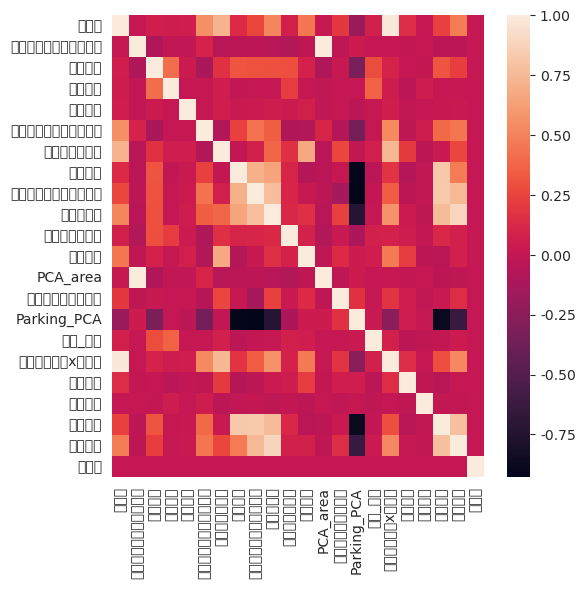

In [32]:
corrs = df_train.corr()
plt.figure(figsize=(6, 6))
sns.heatmap(corrs)

In [33]:
corrs

,總價元,土地移轉總面積平方公尺,建物型態,主要用途,主要建材,建物移轉總面積平方公尺,單價元平方公尺,車位類別,車位移轉總面積平方公尺,車位總價元,...,PCA_area,車位單價元平方公尺,Parking_PCA,隔間_編碼,建物平方公尺x單價元,土地數量,建物數量,車位數量,車位總價,總間數
總價元,1.00,0.01,0.06,0.05,0.06,0.55,0.72,0.13,0.26,0.52,...,0.02,0.20,-0.19,0.08,0.99,0.14,0.00,0.24,0.47,-0.00
土地移轉總面積平方公尺,0.01,1.00,-0.09,-0.01,-0.01,0.09,-0.05,-0.05,-0.03,-0.05,...,1.00,-0.02,0.04,0.00,0.00,-0.01,0.01,-0.03,-0.03,-0.00
建物型態,0.06,-0.09,1.00,0.41,0.03,-0.12,0.17,0.31,0.31,0.29,...,-0.09,0.02,-0.33,0.28,0.09,0.00,-0.01,0.31,0.22,-0.00
主要用途,0.05,-0.01,0.41,1.00,-0.00,0.01,0.05,-0.01,0.01,-0.00,...,-0.01,0.00,0.00,0.37,0.05,-0.03,0.05,0.01,0.01,-0.00
主要建材,0.06,-0.01,0.03,-0.00,1.00,0.01,0.06,0.03,0.03,0.04,...,-0.01,0.01,-0.03,0.01,0.06,-0.01,0.00,0.02,0.02,-0.00
建物移轉總面積平方公尺,0.55,0.09,-0.12,0.01,0.01,1.00,-0.08,0.23,0.42,0.35,...,0.10,-0.06,-0.35,0.01,0.53,-0.02,0.05,0.40,0.45,-0.00
單價元平方公尺,0.72,-0.05,0.17,0.05,0.06,-0.08,1.00,-0.01,0.07,0.38,...,-0.05,0.25,-0.01,0.08,0.74,0.21,-0.03,0.02,0.26,-0.00
車位類別,0.13,-0.05,0.31,-0.01,0.03,0.23,-0.01,1.00,0.71,0.65,...,-0.04,0.01,-0.91,-0.04,0.17,-0.06,-0.01,0.82,0.47,0.00
車位移轉總面積平方公尺,0.26,-0.03,0.31,0.01,0.03,0.42,0.07,0.71,1.00,0.77,...,-0.03,-0.14,-0.93,-0.00,0.34,-0.03,-0.01,0.83,0.75,0.00
車位總價元,0.52,-0.05,0.29,-0.00,0.04,0.35,0.38,0.65,0.77,1.00,...,-0.05,0.23,-0.74,0.01,0.57,0.03,-0.02,0.76,0.89,0.00


In [36]:
high_corr_columns = corrs.index#[abs(corrs['總價元']) >= 0.1]
tr_df = df_train[high_corr_columns]

In [37]:
tt_columns = [col for col in tr_df.columns if col != '總價元']
val_columns = [col for col in tr_df.columns]

#tt_columns = tt_columns + ['編號']

tt_df = df_test[tt_columns]
val_df = df_valid[val_columns]

In [38]:
#存
tr_df = df_train
tt_df = df_test
val_df = df_valid

# Model

In [39]:
tr_df.columns

Index(['總價元', '土地移轉總面積平方公尺', '建物型態', '主要用途', '主要建材', '建物移轉總面積平方公尺', '單價元平方公尺',
       '車位類別', '車位移轉總面積平方公尺', '車位總價元', '總土地使用分區', '平均房價', 'PCA_area',
       '車位單價元平方公尺', 'Parking_PCA', '隔間_編碼', '建物平方公尺x單價元', '土地數量', '建物數量',
       '車位數量', '車位總價', '總間數'],
      dtype='object')

In [42]:
import xgboost as xgb
import pandas as pd


X_train = tr_df.drop(columns=['總價元'])  # 特徵欄位
y_train = tr_df['總價元']                # 目標變數

X_valid = val_df.drop(columns=['總價元'])  # 驗證特徵
y_valid = val_df['總價元']                # 驗證目標變數


dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(tt_df)

params = {
    'objective': 'reg:absoluteerror',  # 使用 MAE 進行回歸
    'learning_rate': 0.01,
    'max_depth': 10,
    'eval_metric': 'mae'  
}
"""
params = {
    'objective': 'reg:absoluteerror',
    'learning_rate': 0.005,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'alpha': 0.1,
    'lambda': 1.0,
    'eval_metric': 'mae'
}
"""
evallist = [(dtrain, 'train'), (dvalid, 'eval')]
#model = xgb.train(params, dtrain, num_boost_round=1000, evals=evallist)
model = xgb.train(params, dtrain, num_boost_round=3000, evals=evallist, early_stopping_rounds=50)
predictions = model.predict(dtest)

result_df = pd.DataFrame({
    '編號': tt_df.index + 1,  
    '總價元': predictions
})

result_df.to_csv('house_price_predictions.csv', index=False, encoding='utf-8-sig')
print("訓練完成")

[0]	train-mae:5532393.58072	eval-mae:6270757.33625
[1]	train-mae:5487589.79185	eval-mae:6225813.77505
[2]	train-mae:5443079.59215	eval-mae:6181161.85001
[3]	train-mae:5399220.65225	eval-mae:6137235.19110
[4]	train-mae:5355511.33136	eval-mae:6093362.27330
[5]	train-mae:5311547.90932	eval-mae:6049299.91454
[6]	train-mae:5268092.67452	eval-mae:6005639.61389
[7]	train-mae:5225241.52166	eval-mae:5962714.12323
[8]	train-mae:5183663.36059	eval-mae:5921046.57495
[9]	train-mae:5141719.67526	eval-mae:5879024.28673
[10]	train-mae:5100240.62024	eval-mae:5837440.97032
[11]	train-mae:5059460.72450	eval-mae:5796558.29131
[12]	train-mae:5019002.64284	eval-mae:5755898.94689
[13]	train-mae:4979907.02428	eval-mae:5716516.80015
[14]	train-mae:4941137.19051	eval-mae:5677670.68793
[15]	train-mae:4901152.29677	eval-mae:5637291.81182
[16]	train-mae:4861086.76464	eval-mae:5596917.06878
[17]	train-mae:4822256.32630	eval-mae:5557806.80107
[18]	train-mae:4783684.41355	eval-mae:5519065.75288
[19]	train-mae:4745337